##### RatingPoints notebook overview

In this notebook I will investigate the predictive value of rating points data with logistic regression.

##### Imports

###### Packages

In [59]:
import pandas as pd
import numpy as np
import random
import time
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

###### Data

In [42]:
# read in all singles matches
s_matches = pd.read_csv('../Data/singles_matches_df.csv',parse_dates = ['tourney_date'], 
                      infer_datetime_format = True, low_memory=False)

##### Data filtering, randomization and feature engineering

###### Filtering

In [19]:
# select non null ranking points ['tourney_date','winner_id','loser_id','winner_rank_points', 'loser_rank_points']
lr_matches = s_matches[s_matches['loser_rank_points'].notnull() & 
          s_matches['winner_rank_points'].notnull()]
lr_matches = lr_matches[
    ['tourney_date','winner_id','loser_id','winner_rank_points', 
     'loser_rank_points', 'winner_rank', 'loser_rank']]
# get rid of matches in which participants have zero ranking points
lr_matches = lr_matches.query('winner_rank_points != 0 and \
                              loser_rank_points != 0')
lr_matches.index = [inx for inx in range(0,lr_matches.shape[0])]

I'll randomly assign winner and loser rank points to players a and b so that there is no win info in the predictive variables.

###### Randomization

Randomizing the 'winner' and 'loser' to players a and b is necessary to remove outcome information from the predictive variables.

In [53]:
random.seed(1)
player_indicators = random.choices([0,1],k = lr_matches.shape[0],)

# player a rank gets winner's rank points if indicator is 1, otherwise 
# player a gets the loser's rank points if indicator is 0

lr_matches['pa_pts'] = (player_indicators* \
                            lr_matches['winner_rank_points']) + \
                          abs((np.array(player_indicators)-1)* \
                           lr_matches['loser_rank_points'])

# player a rank gets loser's rank points if indicator is 1, otherwise 
# player a gets the winner's rank points if indicator is 0

lr_matches['pb_pts'] = (player_indicators * \
                            lr_matches['loser_rank_points']) + \
                          abs((np.array(player_indicators)-1)* \
                           lr_matches['winner_rank_points'])

# player a wins if outcome is 1, otherwise if outcome is 0 player b wins
lr_matches['outcome'] = player_indicators

###### Feature engineering

I'll next create the two predictors of the victor: differential in rank points and weighted differential in rank points.  

For the highest ranked players, say in the top ten, raw ranking point differential may understate the closeness in ability, while for the lower ranked players with very few ranking points the raw ranking point differential may not identify the full extent of ability differentials.

In [43]:
# raw differential in rank points between player 
lr_matches['rp_diff'] = lr_matches['pa_pts'] - \
                                lr_matches['pb_pts']

# differential weighted by the inverse of the sum of both players' rank points
lr_matches['rp_wt_diff'] = lr_matches['rp_diff']/ \
                                            (lr_matches['pa_pts'] + 
                                            lr_matches['pb_pts'])

lr_matches

,tourney_date,winner_id,loser_id,winner_rank_points,loser_rank_points,winner_rank,loser_rank,player_indicators,pa_rk_pts,pb_rk_pts,outcome,pa_pts,pb_pts,rp_diff,rp_wt_diff
0,1990-01-01,101971,101439,213.0,421.0,114.0,45.0,1,634.0,634.0,1,213.0,421.0,-208.0,-0.328076
1,1990-01-01,101124,100752,437.0,313.0,42.0,62.0,1,750.0,750.0,0,313.0,437.0,-124.0,-0.165333
2,1990-01-01,100790,102000,88.0,133.0,239.0,168.0,0,0.0,0.0,0,133.0,88.0,45.0,0.203620
3,1990-01-01,101421,101482,218.0,168.0,105.0,134.0,0,386.0,386.0,1,218.0,168.0,50.0,0.129534
4,1990-01-01,101332,101320,197.0,505.0,122.0,32.0,0,0.0,0.0,1,197.0,505.0,-308.0,-0.438746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618161,2022-12-26,207134,208892,6.0,3.0,1178.0,1461.0,0,0.0,0.0,1,6.0,3.0,3.0,0.333333
618162,2022-12-26,207987,208519,31.0,12.0,716.0,966.0,1,43.0,43.0,1,31.0,12.0,19.0,0.441860
618163,2022-12-26,144932,209977,23.0,8.0,799.0,1117.0,0,0.0,0.0,0,8.0,23.0,-15.0,-0.483871
618164,2022-12-26,209079,210696,7.0,2.0,1125.0,1548.0,0,0.0,0.0,0,2.0,7.0,-5.0,-0.555556


##### Modeling

Since this is a classification problem I will use logistic regression.  I will include regularization to ensure that all predictors are useful.

In [54]:
# Select the predictive and the target columns and split into train and test
X  = lr_matches[['rp_diff','rp_wt_diff',
                 'pa_pts','pb_pts']]
y = lr_matches['outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y) 

In [48]:
# I will initialize with regularizations between 1.e-01 and 1.e+03
logreg = LogisticRegressionCV(Cs = np.logspace(-1,3,5))

In [55]:
logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]))

In [56]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.6475915828343658, 0.6472997631711768)

array([0, 0, 1, ..., 1, 1, 1])

With 64.75 and 64.73 percent accuracy in predicting the winner, the rating points data does a reasonable job of predicting the outcome.

##### Model Evaluation

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [62]:
test_preds = logreg.predict(X_test)

In [78]:
classification_report(y_test,test_preds)

'              precision    recall  f1-score   support\n\n           0       0.65      0.65      0.65     77060\n           1       0.65      0.64      0.65     77482\n\n    accuracy                           0.65    154542\n   macro avg       0.65      0.65      0.65    154542\nweighted avg       0.65      0.65      0.65    154542\n'

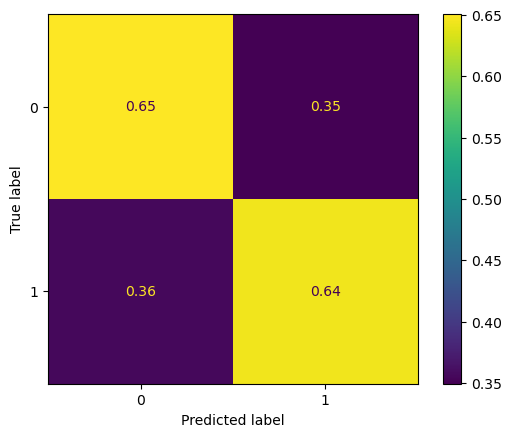

In [76]:
cm = confusion_matrix(y_test,test_preds, normalize='true')

cm_disp = ConfusionMatrixDisplay(confusibon_matrix = cm, display_labels = 
                                 logreg.classes_)
cm_disp.plot()